# 0. imports

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. data

In [12]:
df = pd.read_csv('../01_data/data.csv', delimiter=';')

df.head()

,DATE,Test Group,DAU,Inapp Revenue,Ad Revenue
0,1/1/2021,Test,"600,000","$300,000",$-
1,1/1/2021,Control,"1,400,000","$700,000",$-
2,1/2/2021,Test,"599,700","$300,774",$-
3,1/2/2021,Control,"1,399,300","$701,899",$-
4,1/3/2021,Test,"599,400","$301,743",$-


In [13]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')
df['DAU'] = df['DAU'].replace({',': ''}, regex=True).astype(float)
df['Inapp Revenue'] = df['Inapp Revenue'].replace({',': '', r'\$': '', ' ': ''}, regex=True).astype(float)
df['Ad Revenue'] = df['Ad Revenue'].replace({'\$': '', ',': '', ' ': '', '-': '0'}, regex=True).astype(float)
df['Total Revenue'] = df['Inapp Revenue'] + df['Ad Revenue']

df.head()

,DATE,Test Group,DAU,Inapp Revenue,Ad Revenue,Total Revenue
0,2021-01-01,Test,600000.0,300000.0,0.0,300000.0
1,2021-01-01,Control,1400000.0,700000.0,0.0,700000.0
2,2021-01-02,Test,599700.0,300774.0,0.0,300774.0
3,2021-01-02,Control,1399300.0,701899.0,0.0,701899.0
4,2021-01-03,Test,599400.0,301743.0,0.0,301743.0


In [14]:
df.dtypes

DATE             datetime64[ns]
Test Group               object
DAU                     float64
Inapp Revenue           float64
Ad Revenue              float64
Total Revenue           float64
dtype: object

# 2. analysis

## 2.1. Analyze Net Revenue Impact

In [15]:
test_group = df[df['Test Group'] == 'Test']
control_group = df[df['Test Group'] == 'Control']

pre_test_period = df[df['DATE'] < '2021-01-15']
post_test_period = df[df['DATE'] >= '2021-01-15']

pre_test_revenue = pre_test_period.groupby('Test Group')['Total Revenue'].mean()
post_test_revenue = post_test_period.groupby('Test Group')['Total Revenue'].mean()

revenue_change = post_test_revenue - pre_test_revenue
print("Pre-test Revenue (Mean):\n", pre_test_revenue)
print("Post-test Revenue (Mean):\n", post_test_revenue)
print("Revenue Change:\n", revenue_change)

Pre-test Revenue (Mean):
 Test Group
Control    716656.571429
Test       306471.500000
Name: Total Revenue, dtype: float64
Post-test Revenue (Mean):
 Test Group
Control    770819.363636
Test       341931.045455
Name: Total Revenue, dtype: float64
Revenue Change:
 Test Group
Control    54162.792208
Test       35459.545455
Name: Total Revenue, dtype: float64


## 2.2. Analyzing Heavy Payers

Player Segment Analysis:
                                     DAU  Inapp Revenue    Ad Revenue  \
Test Group Player Segment                                              
Control    Heavy-Payer     1.387819e+06  749756.055556      0.000000   
Test       Mid-Payer       5.160473e+05  309593.500000  18547.722222   

                           Total Revenue  
Test Group Player Segment                 
Control    Heavy-Payer     749756.055556  
Test       Mid-Payer       328141.222222  


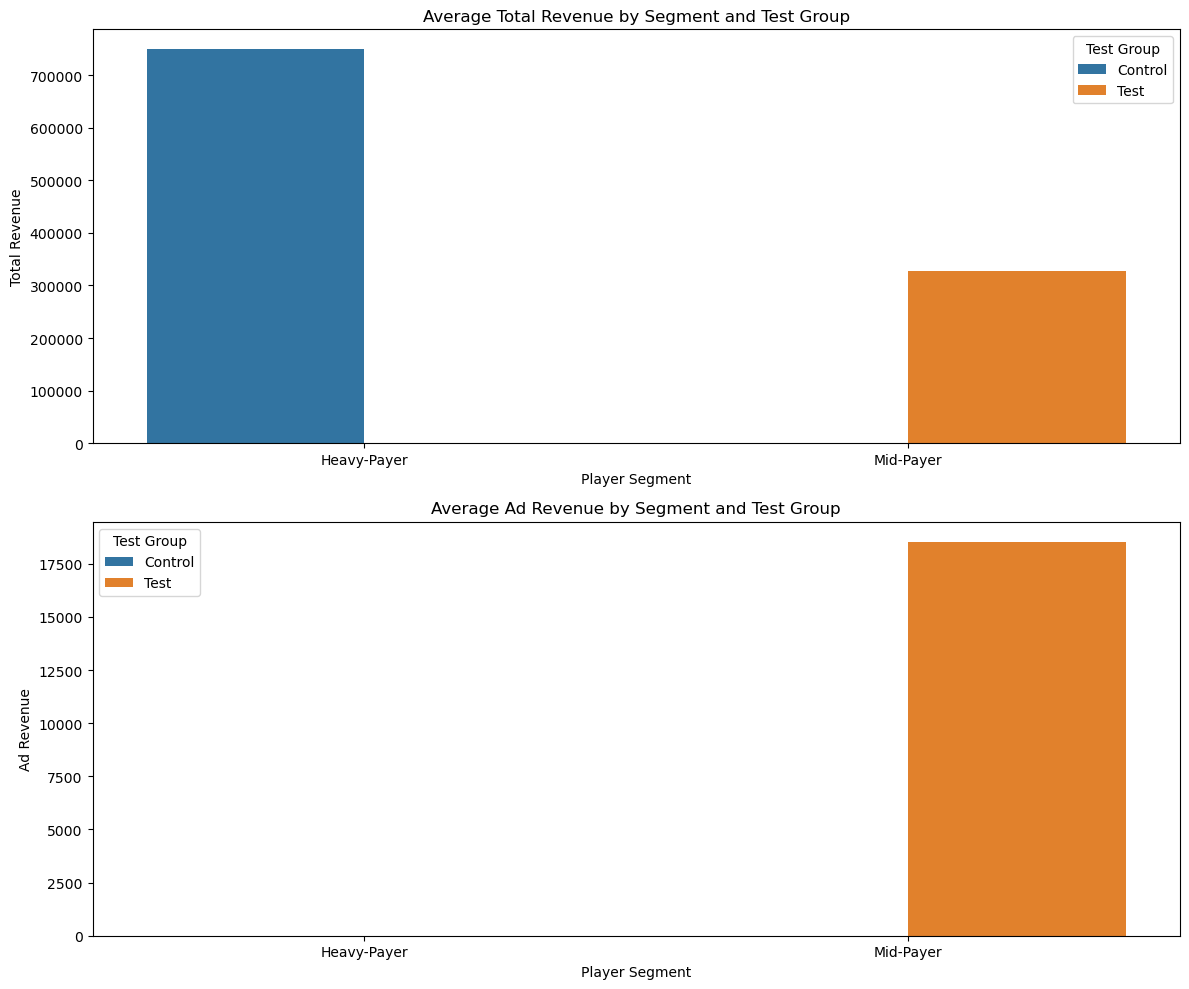

In [16]:
median_inapp_revenue = df['Inapp Revenue'].median()

def segment_players(row):
    if row['Inapp Revenue'] == 0:
        return 'Non-Payer'
    elif row['Inapp Revenue'] <= median_inapp_revenue:
        return 'Mid-Payer'
    else:
        return 'Heavy-Payer'

df['Player Segment'] = df.apply(segment_players, axis=1)

segmentation = df.groupby(['Test Group', 'Player Segment'])[['DAU', 'Inapp Revenue', 'Ad Revenue', 'Total Revenue']].mean()

print("Player Segment Analysis:\n", segmentation)

fig, axes = plt.subplots(2, 1, figsize=(12, 10))
sns.barplot(data=segmentation.reset_index(), x='Player Segment', y='Total Revenue', hue='Test Group', ax=axes[0])
axes[0].set_title('Average Total Revenue by Segment and Test Group')
sns.barplot(data=segmentation.reset_index(), x='Player Segment', y='Ad Revenue', hue='Test Group', ax=axes[1])
axes[1].set_title('Average Ad Revenue by Segment and Test Group')
plt.tight_layout()
plt.show()

## 2.3. Reasons Why Heavy Payers Are Not Profitable

In [17]:
heavy_payers_test = df[(df['Player Segment'] == 'Heavy-Payer') & (df['Test Group'] == 'Test')]

print("Analysis of Heavy Payers (Test Group):\n", heavy_payers_test.describe())

Analysis of Heavy Payers (Test Group):
        DAU  Inapp Revenue  Ad Revenue  Total Revenue
count  0.0            0.0         0.0            0.0
mean   NaN            NaN         NaN            NaN
std    NaN            NaN         NaN            NaN
min    NaN            NaN         NaN            NaN
25%    NaN            NaN         NaN            NaN
50%    NaN            NaN         NaN            NaN
75%    NaN            NaN         NaN            NaN
max    NaN            NaN         NaN            NaN


Possible reasons why heavy payers are not profitable:
- Heavy payers may reduce in-app purchases due to ad rewards.
- Rewarded ads may distract from core monetization mechanics.
- Heavy payers might be sensitive to changes that shift focus away from in-app purchases.

Suggestion to Reduce Churn from Ads
Strategies:
- Tailor ads to align with player preferences (e.g., offer game genres they like).
- Limit ads for heavy payers or offer premium "ad-free" options.
- Introduce incentives to keep players in the current game (e.g., higher chip rewards for staying).

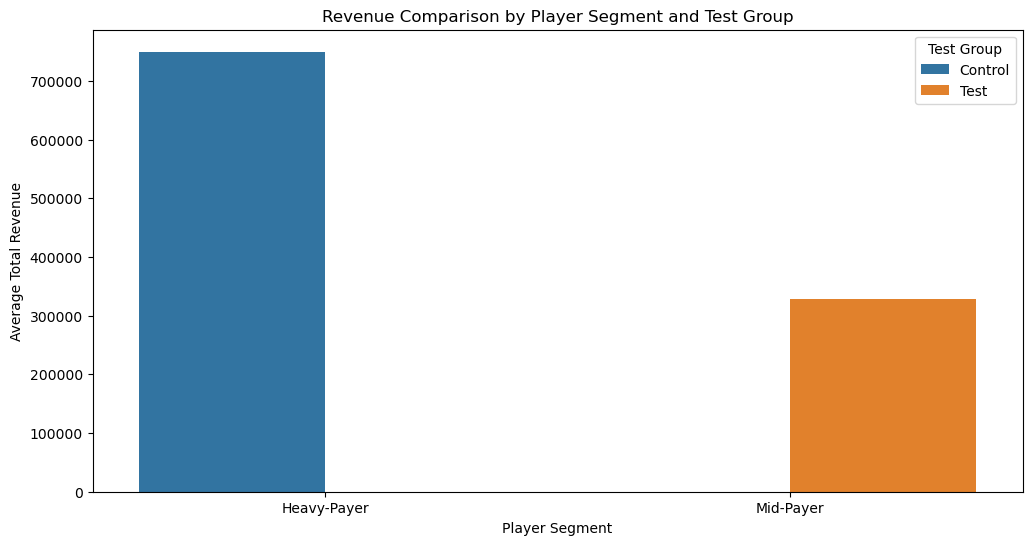

In [18]:
task_force_data = segmentation.reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=task_force_data, x='Player Segment', y='Total Revenue', hue='Test Group', ax=ax)
ax.set_title('Revenue Comparison by Player Segment and Test Group')
ax.set_xlabel('Player Segment')
ax.set_ylabel('Average Total Revenue')
plt.show()


Final Recommendation

In [19]:
if revenue_change['Test'] > revenue_change['Control']:
    print("Recommendation: Roll out the feature to all users, as the net revenue has increased.")
else:
    print("Recommendation: Do NOT roll out the feature universally. Further refinement is required.")

Recommendation: Do NOT roll out the feature universally. Further refinement is required.
